In [1]:
import pandas as pd
import numpy as np
import os
import sys
from scipy.stats.mstats import winsorize
import pandas as pd
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt

def fill_missing_with_flag(df, fill_value=-0.5):
    """
    이전 시점에 데이터가 존재했으나 다음 달에 데이터가 NaN인 경우, NaN을 fill_value로 채웁니다.
    
    Parameters:
    - df (pd.DataFrame): 입력 데이터프레임 (행: 종목, 열: 월)
    - fill_value (float): NaN을 채울 값
    
    Returns:
    - pd.DataFrame: 수정된 데이터프레임
    """
    # 컬럼을 연도-월 순으로 정렬 (이미 정렬되어 있다고 가정)
    sorted_df = df.sort_index(axis=1)
    
    # 원본 데이터를 복사하여 이전 달 데이터 시프트
    prev_month = sorted_df.shift(axis=1)
    
    # 마스크 생성: 이전 달에 데이터가 있고, 현재 달이 NaN인 경우
    mask = prev_month.notna() & sorted_df.isna()
    
    # 마스크된 위치의 NaN 값을 fill_value로 대체
    # 여기서 sorted_df를 수정하지 않고 새로운 DataFrame을 반환
    filled_df = sorted_df.mask(mask, fill_value)
    
    return filled_df

frame = pd.read_csv('data/original_mom.csv', index_col=0)
column_filter = [col for col in frame.columns if col >= '1990-01']
frame = frame[column_filter]

# frame
print(frame['1990-01'].max())

df_winsorized = frame.copy()
for col in frame.columns:
    # NaN이 아닌 값들만 선택
    non_nan_values = frame[col].dropna()
    # Winsorize 적용
    winsorized_values = non_nan_values.clip(lower = -0.95, upper=1.5) # winsorize(non_nan_values, limits=[0.001, 0.001])
    # 원래 컬럼에 NaN을 제외한 위치에 winsorize된 값을 할당
    df_winsorized[col].loc[non_nan_values.index] = winsorized_values

# 최종 winsorized 데이터의 '1990-01' 열에서의 최대값 확인
final_max_value = df_winsorized.max()
print(final_max_value)

12.0


/tmp/ipykernel_1244563/3103996282.py:53: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_winsorized[col].loc[non_nan_values.index] = winsorized_values
/tmp/ipykernel_1244563/3103996282.py:53: FutureWarning: ChainedAssignmentError: behaviour

1990-01    1.5
1990-02    1.5
1990-03    1.5
1990-04    1.5
1990-05    1.5
          ... 
2022-04    1.5
2022-05    1.5
2022-06    1.5
2022-07    1.5
2022-08    1.5
Length: 392, dtype: float64


/tmp/ipykernel_1244563/3103996282.py:53: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_winsorized[col].loc[non_nan_values.index] = winsorized_values
/tmp/ipykernel_1244563/3103996282.py:53: FutureWarning: ChainedAssignmentError: behaviour

In [3]:
# find max value of index
max_index = final_max_value.idxmax()
max_index

'1990-01'

# Portfolio 성능 도출
* optimized_investment_strategy를 사용할 것

In [4]:
def optimized_investment_strategy(return_data_frame, 
                                  number_of_clusters, 
                                  threshold, batch=1024, bins=64, hidden=128, 
                                  std=0.05, mask =0.05, bm=False, out_filter = 0.5, stoploss=-0.3):
    
    if bm:
        if bm == 'kmeans':
            cluster_dir = f'res/ML_best/K-mean/'
        elif bm == 'agg':
            cluster_dir = f'res/ML_best/Agglomerative/'
        elif bm == 'dbscan':
            cluster_dir = f'res/ML_best/DBSCAN/'
    else:
        cluster_dir = f'res/batch_{batch}_n_bins_{bins}_hidden_{hidden}_std_{std}_mask_{mask}/predictions/{number_of_clusters}_characteristics_us'
        prob_dir = f'res/batch_{batch}_n_bins_{bins}_hidden_{hidden}_std_{std}_mask_{mask}/prob/{number_of_clusters}_characteristics_us'
        
        assert os.path.exists(prob_dir), 'prob_dir does not exist'
        prob_results = glob(prob_dir + '/*')
        prob_results.sort()
        
    cluster_results = glob(cluster_dir + '/*')
    cluster_results.sort()

    all_months = return_data_frame.columns

    cumulative_log_return = 0
    cumulative_returns_list = []
    log_returns_list = []
    # LS_table = []

    progress_bar = tqdm(all_months, desc="Processing assets")
    for idx, current_month in enumerate(progress_bar):

        assert str(cluster_results[idx].split('/')[-1].split('.')[0]) == str(current_month), '월이 일치하지 않음'

        next_month = all_months[idx+1] if idx+1 < len(all_months) else None
        if next_month is None:
            continue
        
        cluster_data = pd.read_csv(cluster_results[idx], index_col=0)

        if not bm:
            prob_data = pd.read_csv(prob_results[idx], index_col='firms')
            # 전체 probability 분포 상에서 상위 25~50%에 해당하는 firm만 선택
            prob_data['max_prob'] = prob_data.max(axis=1)
            median_max_prob = prob_data['max_prob'].quantile(out_filter) # ! 0.65 , 0.75 확연히 뛰어남
            combined_data = cluster_data.merge(prob_data, left_on='firms', right_index=True)
            combined_data['clusters'] = np.where(combined_data['max_prob'] > median_max_prob, combined_data['clusters'], 0)
            cluster_data = combined_data[['clusters', 'mom1']]
            
        cluster_data = cluster_data[cluster_data['clusters'] != 0]
        cluster_data.sort_values(by=['mom1', 'firms'], ascending=[False, True], inplace=True)

        # 스프레드 계산
        cluster_data['spread'] = cluster_data.groupby('clusters')['mom1'].transform(lambda x: x.sort_values(ascending=False).values - x.sort_values(ascending=True).values)
        spreadStd = cluster_data['spread'].std()

        cluster_data['Long_or_Short'] = (-cluster_data['spread'] / cluster_data['spread'].abs())
        cluster_data['inPortfolio'] = cluster_data['spread'].abs() > spreadStd * threshold

        long_firms = cluster_data[(cluster_data['Long_or_Short'] == 1) & cluster_data['inPortfolio']]
        short_firms = cluster_data[(cluster_data['Long_or_Short'] == -1) & cluster_data['inPortfolio']]

        # 포트폴리오 가치 계산
        equityReturnsCopy = copy.deepcopy(return_data_frame)
        EarningNextMonth = equityReturnsCopy[next_month]
        EarningNextMonth[short_firms.index] *= -1
        EarningNextMonth.clip(upper=None, lower=stoploss, inplace=True)  # stop loss less than -0.3
        EarningNextMonth.fillna(-0.5, inplace=True)  # fillna with -0.5 for delisted firms

        # Convert earnings to log returns # todo: rollback
        long_firm_returns = EarningNextMonth[long_firms.index]
        short_firm_returns = EarningNextMonth[short_firms.index]

        log_earning = (long_firm_returns.sum() + short_firm_returns.sum()) / (len(long_firms.index) + len(short_firms.index))
        # log_earning = (long_firm_returns.sum() + short_firm_returns.sum()) / (len(long_firms) + len(short_firms))
        log_returns_list.append(log_earning) #todo:rollback log_returns_list.append(log_earning)

        cumulative_log_return += log_earning
        cumulative_returns_list.append(cumulative_log_return)
        
        progress_bar.set_postfix({'earning': log_earning, 'total number': len(long_firms.index) + len(short_firms.index)})

    print("포트폴리오 누적 수익률: ", np.exp(cumulative_returns_list[-1])-1)       
    return cumulative_returns_list[-1], cumulative_returns_list, log_returns_list

# cumulative_return_kmeans_100, cumulative_returns_list_kmeans_100, log_returns_list_kmeans_100 = optimized_investment_strategy(
#     df_winsorized, number_of_clusters=100, threshold=1, bm='kmeans')

In [5]:
cumulative_return_kmeans_100, cumulative_returns_list_kmeans_100, log_returns_list_kmeans_100 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=100, threshold=1, bm='kmeans')
cumulative_return_agg, cumulative_returns_list_agg, log_returns_list_agg = optimized_investment_strategy(
    df_winsorized, number_of_clusters=100, threshold=1, bm='agg')
cumulative_return_dbscan, cumulative_returns_list_dbscan, log_returns_list_dbscan = optimized_investment_strategy(
    df_winsorized, number_of_clusters=100, threshold=1, bm='dbscan')

Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 누적 수익률:  1673003.15235404


Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 누적 수익률:  107.9549426169919


Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 누적 수익률:  43.12505523514468


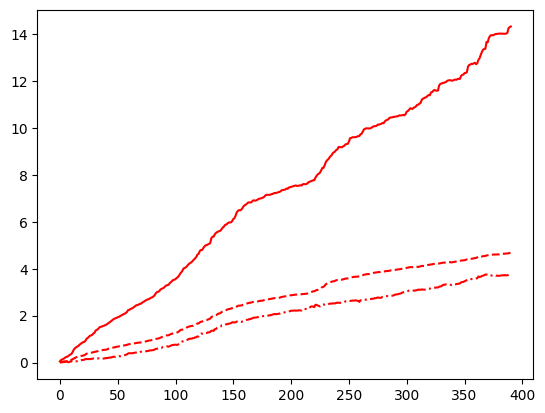

In [6]:
plt.plot((cumulative_returns_list_kmeans_100), label='kmeans', color='red', linestyle='solid')
plt.plot((cumulative_returns_list_agg), label='agg', color='red', linestyle='--')
plt.plot((cumulative_returns_list_dbscan), label='dbscan', color='red', linestyle='-.')

In [156]:
out_filter = 0.7 # ! Outlier filter
thres = 1
batch = 1024
hidden = 128
bins = 64
std = 0.05
mask = 0.05

cumulative_return_1, cumulative_returns_list_1, log_returns_list_1 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=10, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)

cumulative_return_2, cumulative_returns_list_2, log_returns_list_2 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=20, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)

cumulative_return_3, cumulative_returns_list_3, log_returns_list_3 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=30, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)


cumulative_return_4, cumulative_returns_list_4, log_returns_list_4 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=40, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std,out_filter=out_filter)

cumulative_return_5, cumulative_returns_list_5, log_returns_list_5 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=50, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)


Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 누적 수익률:  474.1819859707478


Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 누적 수익률:  2634.718792310982


Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 누적 수익률:  1647.2699388035512


Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 누적 수익률:  10279.084661690576


Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 누적 수익률:  19994.38471174431


In [151]:
# ## 신규 옵션들 

cumulative_return_7, cumulative_returns_list_7, log_returns_list_7 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=50, threshold=thres, batch=1024, bins=bins, hidden=hidden, mask=0.1, std=0.1, out_filter=out_filter)

# cumulative_return_8, cumulative_returns_list_8, log_returns_list_8 = optimized_investment_strategy(
#     df_winsorized, number_of_clusters=50, threshold=thres, batch=1024, bins=bins, hidden=hidden, mask=0.01, std=0.05, out_filter=out_filter)    

# cumulative_return_9, cumulative_returns_list_9, log_returns_list_9 = optimized_investment_strategy(
#     df_winsorized, number_of_clusters=50, threshold=thres, batch=batch, bins=bins, hidden=hidden, mask=0.05, std=0.05, out_filter=out_filter)

Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

IndexError: list index out of range

In [157]:
sp = pd.read_csv('data/sp500.csv', index_col=0)

# Save results of cumulative returns
cumulative_returns = {
    'kmeans_100': cumulative_returns_list_kmeans_100,
    'agg': cumulative_returns_list_agg,
    'dbscan': cumulative_returns_list_dbscan,
    'contrastive_1': cumulative_returns_list_1,
    'contrastive_2': cumulative_returns_list_2,
    'contrastive_3': cumulative_returns_list_3,
    'contrastive_4': cumulative_returns_list_4,
    'contrastive_5': cumulative_returns_list_5,
    # '6': cumulative_returns_list_6,
    # '7': cumulative_returns_list_7
}

cumulative_returns_df = pd.DataFrame(cumulative_returns, index = sp.index[:-1])
#cumulative_returns_df.to_csv(f'res/cumulative_returns_o{out_filter}_thres{thres}.csv')

# 최대 낙폭(Maximum Drawdown, MDD) 계산 함수
def calculate_mdd(log_returns):
    # 월별 로그 수익률의 누적합을 취해 누적 로그 수익률을 복원합니다.
    cum_log_return = np.cumsum(log_returns)
    # 누적 로그 수익률을 지수 함수로 복원하면 누적 복리 수익률가 됩니다.
    cumulative_returns = np.exp(cum_log_return)
    # 누적 수익률의 누적 최댓값
    max_cumulative_returns = pd.Series(cumulative_returns).cummax()
    # 각 시점별 drawdown 계산: (현재 누적 수익률 - 최대 누적 수익률) / 최대 누적 수익률
    drawdown = (cumulative_returns - max_cumulative_returns) / max_cumulative_returns
    # 최대 낙폭은 drawdown의 최솟값(가장 낮은 값)
    mdd = drawdown.min()
    return mdd

# 소르티노 비율(Sortino Ratio)와 하방 변동성 계산 함수
def calculate_sortino_ratio(returns, target_return=0):
    # 월별 평균 수익률
    expected_return = np.mean(returns)
    # 목표 수익률보다 낮은(하방) 수익률만 선택
    downside_returns = [ret for ret in returns if ret < target_return]
    # 하방 변동성: 표본 표준편차 (ddof=1)
    downside_deviation = np.std(downside_returns, ddof=1) if len(downside_returns) > 1 else np.nan
    # 소르티노 비율: (평균 수익률 - 목표 수익률) / 하방 변동성
    sortino_ratio = (expected_return - target_return) / downside_deviation if downside_deviation != 0 else np.nan
    return sortino_ratio, downside_deviation

# 하나의 시계열(한 모델)에 대한 각 metric 계산 함수
def calculate_metrics_for_column(series, target_return=0.0):
    # 입력 series는 월별 누적 로그 수익률입니다.
    # 월별 로그 수익률은 diff()를 통해 복원할 수 있습니다.
    monthly_returns = series.diff().dropna().values
    
    # 연환산 수익률 (월별 평균 수익률에 12를 곱함)
    annual_return = np.mean(monthly_returns) * 12
    # 연환산 표준편차 (월별 표준편차에 sqrt(12)를 곱함)
    annual_std = np.std(monthly_returns, ddof=1) * np.sqrt(12)
    # 샤프 비율 계산 (무위험 수익률 0 가정)
    sharpe_ratio = annual_return / annual_std if annual_std != 0 else np.nan
    
    # 소르티노 비율 및 하방 변동성 계산
    sortino_ratio, downside_deviation = calculate_sortino_ratio(monthly_returns, target_return)
    # 최대 낙폭 계산 (월별 로그 수익률 기반)
    mdd = calculate_mdd(monthly_returns)
    
    return annual_return, annual_std, downside_deviation, mdd, sharpe_ratio, sortino_ratio

# DataFrame의 각 컬럼에 대해 metric들을 계산하는 함수
def calculate_metrics_df(df, target_return=0.0):
    metrics_dict = {}
    # 각 컬럼별로 반복
    for col in df.columns:
        metrics = calculate_metrics_for_column(df[col], target_return)
        metrics_dict[col] = {
            "Annual Return": metrics[0],
            "Annual Std": metrics[1],
            "Downside Deviation": metrics[2],
            "Max Drawdown": metrics[3],
            "Sharpe Ratio": metrics[4],
            "Sortino Ratio": metrics[5]
        }
    # 결과를 DataFrame으로 변환 (각 행이 모델별 metric)
    metrics_df = pd.DataFrame(metrics_dict)
    return metrics_df.transpose()


from_2020 = cumulative_returns_df.loc['2000-01':,]
from_2020 -= cumulative_returns_df.loc['1999-12',:]

<Axes: xlabel='Date'>

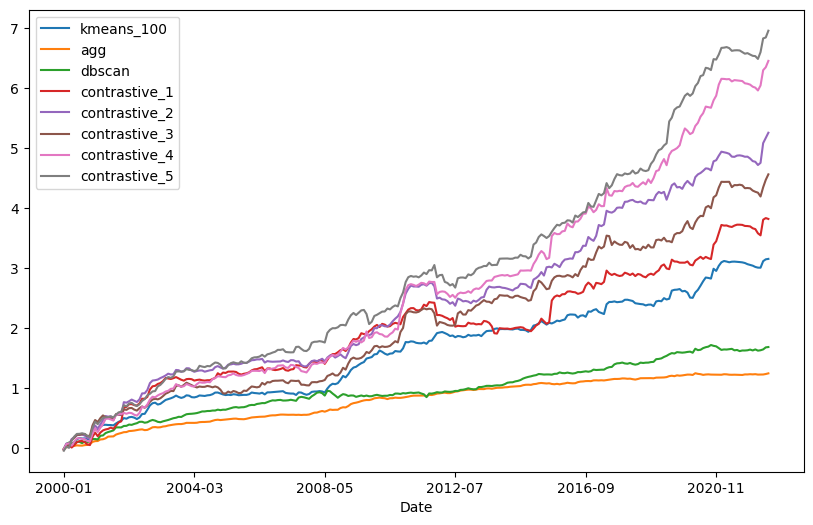

In [158]:
from_2020.plot(figsize=(10,6))

In [159]:
calculate_metrics_df(from_2020)

,Annual Return,Annual Std,Downside Deviation,Max Drawdown,Sharpe Ratio,Sortino Ratio
kmeans_100,0.140962,0.115478,0.012440,-0.136096,1.220681,0.944251
agg,0.056021,0.028015,0.003524,-0.028596,1.999698,1.324760
dbscan,0.075437,0.059903,0.009865,-0.110713,1.259316,0.637231
contrastive_1,0.171065,0.186456,0.027123,-0.408856,0.917453,0.525586
contrastive_2,0.234498,0.189785,0.026216,-0.317787,1.235594,0.745408
contrastive_3,0.203784,0.186731,0.028803,-0.250968,1.091325,0.589594
contrastive_4,0.287671,0.212830,0.029536,-0.236436,1.351649,0.811628
contrastive_5,0.311190,0.200493,0.031584,-0.313751,1.552120,0.821074


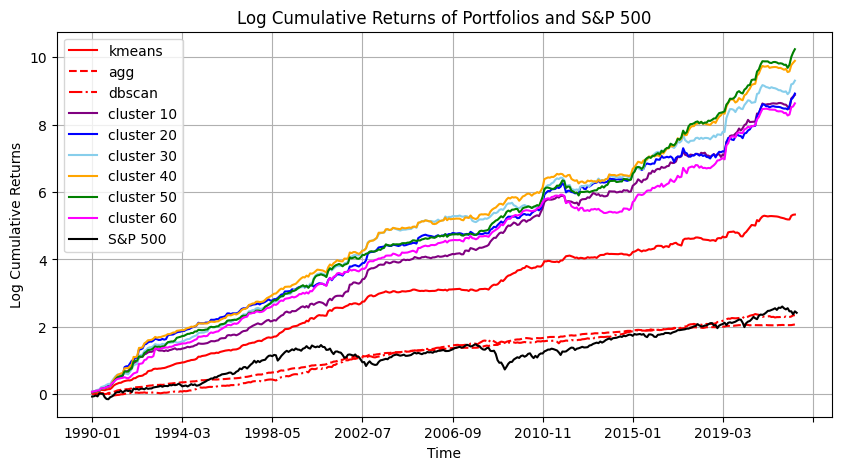

In [63]:
plt.figure(figsize=(10, 5))

# plt.plot(np.cumsum(log_returns_list_kmeans_10), label='kmeans 10', color='blue', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_kmeans_20)+1), label='kmeans 20', color='orange', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_kmeans_30)+1), label='kmeans 30', color='green', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_kmeans_50)+1), label='kmeans 50', color='black', linestyle='solid')
plt.plot((cumulative_returns_list_kmeans_100), label='kmeans', color='red', linestyle='solid')
plt.plot((cumulative_returns_list_agg), label='agg', color='red', linestyle='--')
plt.plot((cumulative_returns_list_dbscan), label='dbscan', color='red', linestyle='-.')

plt.plot((cumulative_returns_list_1), label='cluster 10', color='purple', linestyle='solid')
plt.plot((cumulative_returns_list_2), label='cluster 20', color='blue', linestyle='solid')
plt.plot((cumulative_returns_list_3), label='cluster 30', color='skyblue', linestyle='solid')
plt.plot((cumulative_returns_list_4), label='cluster 40', color='orange', linestyle='solid')
plt.plot((cumulative_returns_list_5), label='cluster 50', color='green', linestyle='solid')
plt.plot((cumulative_returns_list_6), label='cluster 60', color='magenta', linestyle='solid')
#plt.plot((cumulative_returns_list_7), label='cluster 70', color='brown', linestyle='solid')

np.log1p((sp['Monthly Returns']+1).cumprod()-1).plot(label='S&P 500', color='black', linestyle='solid')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Log Cumulative Returns')
plt.title('Log Cumulative Returns of Portfolios and S&P 500')
plt.grid(True)
plt.show()

In [86]:
def calculate_metrics(log_returns_list, target_return=0.0):

    # Max Drawdown Percent
    def calculate_mdd(log_returns_list):
        cum_log_return = np.cumsum(log_returns_list)
        cumulative_returns = np.exp(cum_log_return)
        max_cumulative_returns = pd.Series(cumulative_returns).cummax()
        drawdown = (cumulative_returns - max_cumulative_returns) / max_cumulative_returns
        mdd = drawdown.min()
        return mdd
    
    def calculate_sortino_ratio(returns, target_return=0):
        # 예상 수익률 계산
        expected_return = np.mean(returns)
        
        # downside deviation 계산
        downside_returns = [ret for ret in returns if ret < target_return]
        downside_deviation = np.std(downside_returns, ddof=1)
        
        # Sortino 비율 계산
        sortino_ratio = (expected_return - target_return) / downside_deviation
        
        return sortino_ratio, downside_deviation
    
    max_drawdown = calculate_mdd(log_returns_list)
    
    # Annual Return and Standard deviation (based on log returns)
    annual_return = np.mean(log_returns_list) * 12
    standard_deviation = np.std(log_returns_list) * np.sqrt(12)

    # sharpe ratio
    sharpe_ratio = (annual_return) / standard_deviation
    
    sortino_ratio, downside_deviation = calculate_sortino_ratio(log_returns_list)
    return annual_return, standard_deviation, downside_deviation, max_drawdown, sharpe_ratio, sortino_ratio


annual_return_kmeans, standard_deviation_kmeans, down_kmeans, mdd_kmeans, sharpe_ratio_kmeans, sortiono_kmeans = calculate_metrics(log_returns_list_kmeans_100)
annual_return_agg, standard_deviation_agg, down_agg, mdd_agg, sharpe_ratio_agg, sortino_agg = calculate_metrics(log_returns_list_agg)
annual_return_dbscan, standard_deviation_dbscan, down_dbscan, mdd_dbscan, sharpe_ratio_dbscan, sortino_dbscan = calculate_metrics(log_returns_list_dbscan)

annual_return1, standard_deviation1, down1, mdd1, sharpe_ratio1, sortino1 = calculate_metrics(log_returns_list_1)
annual_return2, standard_deviation2, down2, mdd2, sharpe_ratio2, sortino2 = calculate_metrics(log_returns_list_2)
annual_return3, standard_deviation3, down3, mdd3, sharpe_ratio3, sortino3 = calculate_metrics(log_returns_list_3)
annual_return4, standard_deviation4, down4, mdd4, sharpe_ratio4, sortino4 = calculate_metrics(log_returns_list_4)
annual_return5, standard_deviation5, down5, mdd5, sharpe_ratio5, sortino5 = calculate_metrics(log_returns_list_5)
annual_return6, standard_deviation6, down6, mdd6, sharpe_ratio6, sortino6 = calculate_metrics(log_returns_list_6)
#sharpe_ratio7, annual_return7, standard_deviation7, mdd7 , sortino7, down7 = calculate_metrics(log_returns_list_7)

df = pd.DataFrame({'sharpe_ratio': [sharpe_ratio_kmeans, sharpe_ratio_agg, sharpe_ratio_dbscan, sharpe_ratio1, sharpe_ratio2,sharpe_ratio3, sharpe_ratio4, sharpe_ratio5, sharpe_ratio6,],
                     'annual_return': [annual_return_kmeans, annual_return_agg, annual_return_dbscan, annual_return1, annual_return2,annual_return3, annual_return4, annual_return5, annual_return6,],
                     'standard_deviation': [standard_deviation_kmeans, standard_deviation_agg, standard_deviation_dbscan, standard_deviation1, standard_deviation2, standard_deviation3, standard_deviation4, standard_deviation5, standard_deviation6, ],
                     'sortino_ratio': [sortiono_kmeans,sortino_agg, sortino_dbscan, sortino1, sortino2, sortino3, sortino4, sortino5, sortino6, ],
                    'max_drawdown': [mdd_kmeans, mdd_agg, mdd_dbscan, mdd1, mdd2, mdd3, mdd4, mdd5, mdd6, ],
                    'downside_deviation': [down_kmeans, down_agg,down_dbscan , down1, down2, down3, down4, down5, down6, ]},
                    index=['kmeans', 'agg', 'dbscan','cluster1','cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6',])
# best sharpe ratio
print(df.idxmax())
df.T

sharpe_ratio               agg
annual_return         cluster5
standard_deviation    cluster3
sortino_ratio              agg
max_drawdown               agg
downside_deviation    cluster5
dtype: object


,kmeans,agg,dbscan,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
sharpe_ratio,1.611777,2.271071,1.299108,1.479475,1.434860,1.482019,1.696535,1.749654,1.475408
annual_return,0.163626,0.063486,0.071952,0.272593,0.273816,0.285602,0.303654,0.314227,0.264900
standard_deviation,0.101519,0.027954,0.055385,0.184250,0.190831,0.192712,0.178985,0.179594,0.179543
sortino_ratio,1.122299,1.418950,0.630402,0.874732,0.824996,0.837351,1.121376,0.905693,0.784352
max_drawdown,-0.136096,-0.028596,-0.110713,-0.244669,-0.262093,-0.315727,-0.248258,-0.360880,-0.419283
downside_deviation,0.012150,0.003728,0.009511,0.025969,0.027658,0.028423,0.022566,0.028912,0.028144


In [69]:
df

,sharpe_ratio,annual_return,standard_deviation,sortino_ratio,max_drawdown,downside_deviation
kmeans,1.611777,0.163626,0.101519,1.122299,-0.136096,0.012150
agg,2.271071,0.063486,0.027954,1.418950,-0.028596,0.003728
dbscan,1.299108,0.071952,0.055385,0.630402,-0.110713,0.009511
cluster1,1.479475,0.272593,0.184250,0.874732,-0.244669,0.025969
cluster2,1.434860,0.273816,0.190831,0.824996,-0.262093,0.027658
cluster3,1.482019,0.285602,0.192712,0.837351,-0.315727,0.028423
cluster4,1.696535,0.303654,0.178985,1.121376,-0.248258,0.022566
cluster5,1.749654,0.314227,0.179594,0.905693,-0.360880,0.028912
cluster6,1.475408,0.264900,0.179543,0.784352,-0.419283,0.028144


In [70]:
calculate_metrics(log_returns_list_kmeans_100)

(0.16362598372634873,
 0.1015189973655018,
 0.012149616066527912,
 -0.1360957619824231,
 1.6117769872888061,
 1.1222987269061182)

In [8]:
sharpe_ratio_kmeans, annual_return_kmeans, standard_deviation_kmeans, mdd_kmeans, sortiono_kmeans, down_kmeans = calculate_metrics(log_returns_list_kmeans_100)
sharpe_ratio_agg, annual_return_agg, standard_deviation_agg, mdd_agg, sortino_agg, down_agg = calculate_metrics(log_returns_list_agg)
sharpe_ratio_dbscan, annual_return_dbscan, standard_deviation_dbscan, mdd_dbscan, sortino_dbscan, down_dbscan = calculate_metrics(log_returns_list_dbscan)

sharpe_ratio1, annual_return1, standard_deviation1, mdd1 , sortino1, down1 = calculate_metrics(log_returns_list_1)
sharpe_ratio2, annual_return2, standard_deviation2, mdd2 , sortino2, down2 = calculate_metrics(log_returns_list_2)
sharpe_ratio3, annual_return3, standard_deviation3, mdd3 , sortino3, down3 = calculate_metrics(log_returns_list_3)
sharpe_ratio4, annual_return4, standard_deviation4, mdd4 , sortino4, down4 = calculate_metrics(log_returns_list_4)
sharpe_ratio5, annual_return5, standard_deviation5, mdd5 , sortino5, down5 = calculate_metrics(log_returns_list_5)
sharpe_ratio6, annual_return6, standard_deviation6, mdd6 , sortino6, down6 = calculate_metrics(log_returns_list_6)
sharpe_ratio7, annual_return7, standard_deviation7, mdd7 , sortino7, down7 = calculate_metrics(log_returns_list_7)

df = pd.DataFrame({'sharpe_ratio': [sharpe_ratio_kmeans, sharpe_ratio_agg, sharpe_ratio_dbscan, sharpe_ratio1, sharpe_ratio2,sharpe_ratio3, sharpe_ratio4, sharpe_ratio5, sharpe_ratio6, sharpe_ratio7],
                     'annual_return': [annual_return_kmeans, annual_return_agg, annual_return_dbscan, annual_return1, annual_return2,annual_return3, annual_return4, annual_return5, annual_return6, annual_return7],
                     'standard_deviation': [standard_deviation_kmeans, standard_deviation_agg, standard_deviation_dbscan, standard_deviation1, standard_deviation2, standard_deviation3, standard_deviation4, standard_deviation5, standard_deviation6, standard_deviation7],
                     'sortino_ratio': [sortiono_kmeans,sortino_agg, sortino_dbscan, sortino1, sortino2, sortino3, sortino4, sortino5, sortino6, sortino7],
                    'max_drawdown': [mdd_kmeans, mdd_agg, mdd_dbscan, mdd1, mdd2, mdd3, mdd4, mdd5, mdd6, mdd7],
                    'downside_deviation': [down_kmeans, down_agg,down_dbscan , down1, down2, down3, down4, down5, down6, down7]},
                    index=['kmeans', 'agg', 'dbscan','cluster1','cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7'])
# best sharpe ratio
print(df.idxmax())
df.T

sharpe_ratio               agg
annual_return         cluster5
standard_deviation    cluster5
sortino_ratio              agg
max_drawdown               agg
downside_deviation    cluster3
dtype: object


,kmeans,agg,dbscan,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7
sharpe_ratio,1.611777,2.271071,1.299108,1.494200,1.444096,1.410100,1.649937,1.568959,1.170622,1.054810
annual_return,0.163626,0.063486,0.071952,0.307520,0.301829,0.320600,0.333333,0.357523,0.243172,0.177392
standard_deviation,0.101519,0.027954,0.055385,0.205809,0.209009,0.227360,0.202028,0.227873,0.207729,0.168175
sortino_ratio,1.122299,1.418950,0.630402,0.927573,0.803019,0.748772,1.114564,0.899664,0.598149,0.698735
max_drawdown,-0.136096,-0.028596,-0.110713,-0.244558,-0.329128,-0.333599,-0.342182,-0.423489,-0.483677,-0.278779
downside_deviation,0.012150,0.003728,0.009511,0.027628,0.031322,0.035681,0.024923,0.033116,0.033878,0.021156


In [4]:

out_filter = 0.5 # ! Outlier filter : 0 ~ 0.99 사이 어딘가? 0.5(2.5) 0.75(2.55)
thres = 1
batch = 256
hidden = 128
bins = 64
std = 0.1
mask = 0.1

# cumulative_return_1, cumulative_returns_list_1, log_returns_list_1 = optimized_investment_strategy(
#     df_winsorized, number_of_clusters=40, threshold=thre, batch=batch, bins=bins, hidden=hidden, mask=mask, std= std,out_filter=out_filter)
cumulative_return_2, cumulative_returns_list_2, log_returns_list_2 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=50, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std,out_filter=out_filter)
cumulative_return_3, cumulative_returns_list_3, log_returns_list_3 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=60, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)
cumulative_return_4, cumulative_returns_list_4, log_returns_list_4 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=70, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)
cumulative_return_5, cumulative_returns_list_5, log_returns_list_5 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=80, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)
cumulative_return_6, cumulative_returns_list_6, log_returns_list_6 = optimized_investment_strategy(
    df_winsorized, number_of_clusters=90, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)
# cumulative_return_7, cumulative_returns_list_7, log_returns_list_7 = optimized_investment_strategy(
#     df_winsorized, number_of_clusters=100, threshold=thres, batch=batch, bins=bins, hidden=hidden,mask=mask, std= std, out_filter=out_filter)

Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  1067.7582478674713


Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  434.9883717164765


Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  829.3783690459907


Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

포트폴리오 수익률:  1538.2431049868542


Processing assets:   0%|          | 0/392 [00:00<?, ?it/s]

IndexError: list index out of range

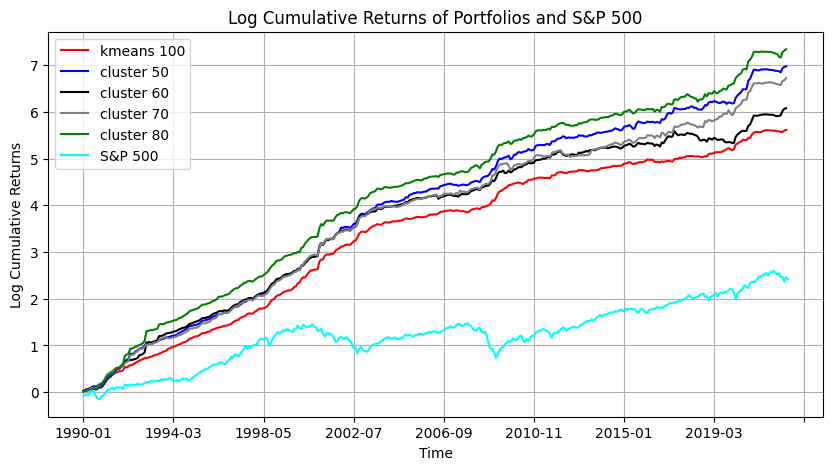

In [5]:
sp = pd.read_csv('data/sp500.csv', index_col=0)

plt.figure(figsize=(10, 5))

# plt.plot(np.cumsum(log_returns_list_kmeans_10), label='kmeans 10', color='blue', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_kmeans_20)+1), label='kmeans 20', color='orange', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_kmeans_30)+1), label='kmeans 30', color='green', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_kmeans_50)+1), label='kmeans 50', color='black', linestyle='solid')
plt.plot(np.log(np.array(cumulative_returns_list_kmeans_100)+1), label='kmeans 100', color='red', linestyle='solid')

# plt.plot(np.cumsum(log_returns_list_1), label='cluster 10', color='purple', linestyle='solid')
plt.plot(np.cumsum(log_returns_list_2), label='cluster 50', color='blue', linestyle='solid')
plt.plot(np.cumsum(log_returns_list_3), label='cluster 60', color='black', linestyle='solid')
plt.plot(np.cumsum(log_returns_list_4), label='cluster 70', color='grey', linestyle='solid')
plt.plot(np.cumsum(log_returns_list_5), label='cluster 80', color='green', linestyle='solid')
# plt.plot(np.cumsum(log_returns_list_6), label='cluster 90', color='skyblue', linestyle='solid')
# plt.plot(np.cumsum(log_returns_list_7), label='cluster 100', color='orange', linestyle='solid')

np.log((sp['Monthly Returns']+1).cumprod()).plot(label='S&P 500', color='cyan', linestyle='solid')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Log Cumulative Returns')
plt.title('Log Cumulative Returns of Portfolios and S&P 500')
plt.grid(True)
plt.show()

In [ ]:
def calculate_metrics(log_returns_list, target_return=0.0):

    # Max Drawdown Percent
    def calculate_mdd(log_returns_list):
        cum_log_return = np.cumsum(log_returns_list)
        cumulative_returns = np.exp(cum_log_return)
        max_cumulative_returns = pd.Series(cumulative_returns).cummax()
        drawdown = (cumulative_returns - max_cumulative_returns) / max_cumulative_returns
        mdd = drawdown.min()
        return mdd
    
    def calculate_sortino_ratio(returns, target_return=0):
        # 예상 수익률 계산
        expected_return = np.mean(returns)
        
        # downside deviation 계산
        downside_returns = [ret for ret in returns if ret < target_return]
        downside_deviation = np.std(downside_returns, ddof=1)
        
        # Sortino 비율 계산
        sortino_ratio = (expected_return - target_return) / downside_deviation
        
        return sortino_ratio, downside_deviation
    
    max_drawdown = calculate_mdd(log_returns_list)
    
    # Annual Return and Standard Deviation (based on log returns)
    annual_return = np.mean(log_returns_list) * 12
    standard_deviation = np.std(log_returns_list) * np.sqrt(12)

    # Sharpe Ratio
    sharpe_ratio = annual_return / standard_deviation
    
    sortino_ratio, downside_deviation = calculate_sortino_ratio(log_returns_list)

    # 반환 순서를 조정: annual_return, standard_deviation, downside_deviation, max_drawdown, sharpe_ratio, sortino_ratio
    return annual_return, standard_deviation, downside_deviation, max_drawdown, sharpe_ratio, sortino_ratio


# 예시: 각 클러스터별 메트릭 계산 (할당 순서도 위 순서에 맞춰 변경)
annual_return_kmeans, standard_deviation_kmeans, down_kmeans, mdd_kmeans, sharpe_ratio_kmeans, sortino_kmeans = calculate_metrics(log_returns_list_kmeans_100)
annual_return_agg, standard_deviation_agg, down_agg, mdd_agg, sharpe_ratio_agg, sortino_agg = calculate_metrics(log_returns_list_agg)
annual_return_dbscan, standard_deviation_dbscan, down_dbscan, mdd_dbscan, sharpe_ratio_dbscan, sortino_dbscan = calculate_metrics(log_returns_list_dbscan)

annual_return1, standard_deviation1, down1, mdd1, sharpe_ratio1, sortino1 = calculate_metrics(log_returns_list_1)
annual_return2, standard_deviation2, down2, mdd2, sharpe_ratio2, sortino2 = calculate_metrics(log_returns_list_2)
annual_return3, standard_deviation3, down3, mdd3, sharpe_ratio3, sortino3 = calculate_metrics(log_returns_list_3)
annual_return4, standard_deviation4, down4, mdd4, sharpe_ratio4, sortino4 = calculate_metrics(log_returns_list_4)
annual_return5, standard_deviation5, down5, mdd5, sharpe_ratio5, sortino5 = calculate_metrics(log_returns_list_5)
annual_return6, standard_deviation6, down6, mdd6, sharpe_ratio6, sortino6 = calculate_metrics(log_returns_list_6)
annual_return7, standard_deviation7, down7, mdd7, sharpe_ratio7, sortino7 = calculate_metrics(log_returns_list_7)

# DataFrame 생성 시에도 원하는 순서로 배치
df = pd.DataFrame({
    'annual_return': [annual_return_kmeans, annual_return_agg, annual_return_dbscan, annual_return1, annual_return2, annual_return3, annual_return4, annual_return5, annual_return6, annual_return7],
    'standard_deviation': [standard_deviation_kmeans, standard_deviation_agg, standard_deviation_dbscan, standard_deviation1, standard_deviation2, standard_deviation3, standard_deviation4, standard_deviation5, standard_deviation6, standard_deviation7],
    'downside_deviation': [down_kmeans, down_agg, down_dbscan, down1, down2, down3, down4, down5, down6, down7],
    'max_drawdown': [mdd_kmeans, mdd_agg, mdd_dbscan, mdd1, mdd2, mdd3, mdd4, mdd5, mdd6, mdd7],
    'sharpe_ratio': [sharpe_ratio_kmeans, sharpe_ratio_agg, sharpe_ratio_dbscan, sharpe_ratio1, sharpe_ratio2, sharpe_ratio3, sharpe_ratio4, sharpe_ratio5, sharpe_ratio6, sharpe_ratio7],
    'sortino_ratio': [sortino_kmeans, sortino_agg, sortino_dbscan, sortino1, sortino2, sortino3, sortino4, sortino5, sortino6, sortino7]
}, index=['kmeans', 'agg', 'dbscan', 'cluster1','cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7'])

# best sharpe ratio 출력
print(df.idxmax())
df.T

sharpe_ratio            kmeans
annual_return         cluster5
standard_deviation    cluster5
sortino_ratio           kmeans
max_drawdown          cluster3
downside_deviation    cluster4
dtype: object


,kmeans,cluster2,cluster3,cluster4,cluster5
sharpe_ratio,2.557309,2.186716,1.842715,1.998145,2.094267
annual_return,0.187897,0.238677,0.205055,0.229120,0.252622
standard_deviation,0.073475,0.109148,0.111279,0.114666,0.120626
sortino_ratio,2.127729,1.593193,1.046624,1.117455,1.376165
max_drawdown,0.060776,0.081385,0.249612,0.138523,0.162639
downside_deviation,0.006894,0.011592,0.015435,0.015987,0.014183


In [16]:
annual_return_kmeans

0.20261130327631682

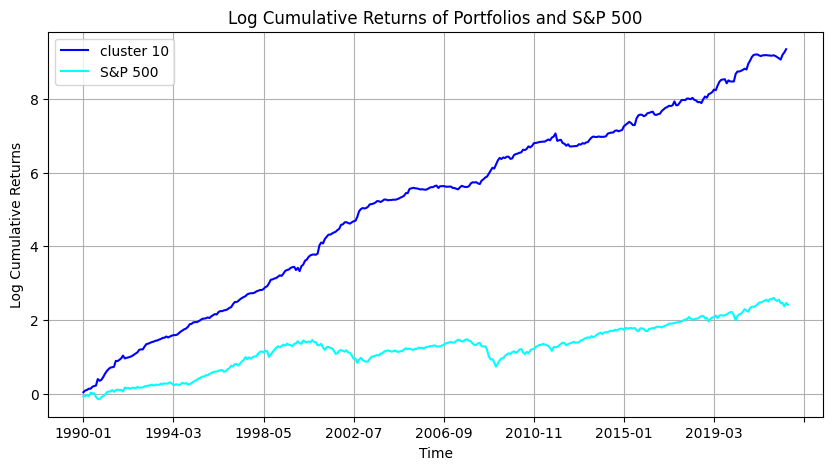

In [35]:
# 데이터 로드
sp = pd.read_csv('sp500.csv', index_col=0)

# 그래프 설정
plt.figure(figsize=(10, 5))

# 라인 플롯
plt.plot(np.log(np.array(cumulative_returns_list_10)+1), label='cluster 10', color='blue', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_2)+1), label='cluster 20', color='red', linestyle='dashed')
# plt.plot(np.log(np.array(cumulative_returns_list_3)+1), label='cluster 30', color='green', linestyle='dotted')
# plt.plot(np.log(np.array(cumulative_returns_list_4)+1), label='cluster 40', color='purple', linestyle='dashdot')
# plt.plot(np.log(np.array(cumulative_returns_list_5)+1), label='cluster 50', color='orange', linestyle='solid')
# plt.plot(np.log(np.array(cumulative_returns_list_6)+1), label='cluster 60', color='black', linestyle='dashed')
np.log((sp['Monthly Returns']+1).cumprod()).plot(label='S&P 500', color='cyan', linestyle='solid')

# 레전드
plt.legend()

# 축 레이블
plt.xlabel('Time')
plt.ylabel('Log Cumulative Returns')

# 타이틀
plt.title('Log Cumulative Returns of Portfolios and S&P 500')

# 그리드
plt.grid(True)

# 그래프 표시
plt.show()